# Data Cleaning and Exploratory Analysis


This is an attemp in an exploratory analysis of our dataset in order to help us understand and identify features in the dataset.

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


Vizualizing data helps to illustrate certain attributes of the dataset and display meaningful analytics

In [9]:
data_file = '../data/movieDB.csv'
movies_df = pd.read_csv(data_file)
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8867 entries, 0 to 8866
Data columns (total 7 columns):
url               8867 non-null object
title             8867 non-null object
original_title    8867 non-null object
year              8867 non-null int64
country           8867 non-null object
genre             8867 non-null object
plot              8867 non-null object
dtypes: int64(1), object(6)
memory usage: 485.0+ KB


Data needs to be processed since there are duplicate records. Also the genre information needs to be more comprehensive.
Removing duplicates:

In [10]:
movies_df.drop_duplicates(inplace=True)
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3756 entries, 0 to 8865
Data columns (total 7 columns):
url               3756 non-null object
title             3756 non-null object
original_title    3756 non-null object
year              3756 non-null int64
country           3756 non-null object
genre             3756 non-null object
plot              3756 non-null object
dtypes: int64(1), object(6)
memory usage: 234.8+ KB


Some movie genres happen to contain the county information, for movies where multiple countries were involved. The following code identifies such instances and appends the first element of genre, which happens to be the miss-classified country, to the country column. Afterwards the first element of genre is ommited.

In [11]:
missclassified_genres = [genres for genres in movies_df['genre'].values if genres.split(',')[0] in movies_df['country'].values]
print(missclassified_genres[:5])
# cleaning
while missclassified_genres:
    movies_df.loc[movies_df['genre'].isin(missclassified_genres), 'country'] += ',' + movies_df.loc[movies_df['genre'].isin(missclassified_genres), 'genre'].apply(lambda x: x.split(',')[0])
    movies_df.loc[movies_df['genre'].isin(missclassified_genres), 'genre'] = movies_df[movies_df['genre'].isin(missclassified_genres)]['genre'].apply(lambda x: ','.join(x.split(',')[1:]))
    missclassified_genres = [genres for genres in movies_df['genre'].values if genres.split(',')[0] in movies_df['country'].values]

missclassified_genres

[]


[]

Each movie can be classified to multiple genres most of the times. We conduct a binary relevance analysis to vizualize the distribution of the genres across the datase.

In [12]:
# Get unique genre list
genre_list = list(set([genre  for genres in movies_df['genre'].values for genre in genres.strip().split(',')]))

for genre in genre_list:
    movies_df[genre] = movies_df['genre'].apply(lambda x: 1 if genre in x.split(',') else 0) 

visualization_df = movies_df[genre_list]
visualization_df.head()

,Μεταφυσικό Θρίλερ,Επιστημονικής Φαντασίας,Τρόμου,Ντοκιμαντέρ,Κινούμενα Σχέδια,Κομεντί,Νεανική,Πολιτική,Περιπέτεια,Θρησκευτική,...,Ερωτική,Παρωδία,Γκανγκστερική,Τέρατα,Ιστορική,Υπερήρωες,Πολεμικό Δράμα,Βιογραφία,Μαύρη Κωμωδία,Αθλητική
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Vizualize the number of genres per movie



/home/arvartho/python/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


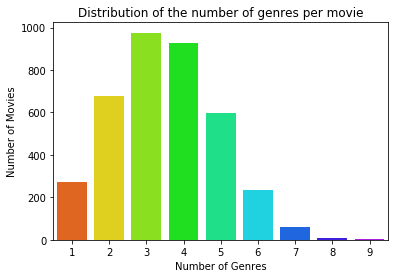

In [13]:
visualization_df['genre_no'] = visualization_df.sum(axis=1)
sns.countplot(x='genre_no', 
              data=visualization_df, 
              palette='gist_rainbow' )
plt.title("Distribution of the number of genres per movie")
plt.xlabel("Number of Genres")
plt.ylabel("Number of Movies")
plt.show()

In [7]:
visualization_df[genre_list].sum().describe()

count      48.000000
mean      274.583333
std       252.263104
min        15.000000
25%        81.750000
50%       197.000000
75%       380.750000
max      1040.000000
dtype: float64

In [40]:
popularity_df = visualization_df[genre_list].sum().sort_values(ascending=False)[:int(visualization_df.shape[1]*.30)]
popular_genre_list = popularity_df.index
unpopular_genre_list = [genre for genre in genre_list if genre not in popular_genre_list]
visualization_df[unpopular_genre_list].sum().sort_values()


Tηλεταινία            15
Χορευτική             32
Θρησκευτική           32
Ντοκιουντράμα         33
Γουέστερν             36
Πολεμικών Τεχνών      52
Πολεμική              57
Παρωδία               59
Ντοκιμαντέρ           65
Καταστροφής           72
Αθλητική              72
Ερωτική               78
Πολιτικό Θρίλερ       83
Γκανγκστερική         86
Μιούζικαλ             89
Ταινία Δρόμου        103
Υπερήρωες            104
Τέρατα               111
Πολεμικό Δράμα       117
Κατασκοπική          122
Μουσική              124
Μεταφυσικό Θρίλερ    129
Νουάρ                137
Σάτιρα               173
Μαύρη Κωμωδία        221
Κινούμενα Σχέδια     224
Πολιτική             224
Τρόμου               232
Μυστηρίου            280
Κομεντί              283
Έπος                 312
Ιστορική             313
Σινεφίλ              315
Νεανική              319
dtype: int64

From the above output we can conclude that the minimum number of times a genre occurs is 15 with the maximum value being as high as 1040. Almost 50% of the genres have occurred 197 number of times. 75% of the genres have occurred more than 81 times and 25% of the genres have occured in more than 380 movies. We can also get all these information summarized in the box plot below.

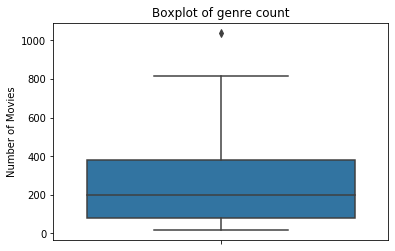

In [8]:
sns.boxplot(visualization_df[genre_list].sum(), orient='v')
plt.title("Boxplot of genre count")
plt.ylabel("Number of Movies")
plt.show()

#### Visualizing the genre occurance

We try to visualize the genre frequency popularity as a word-cloud

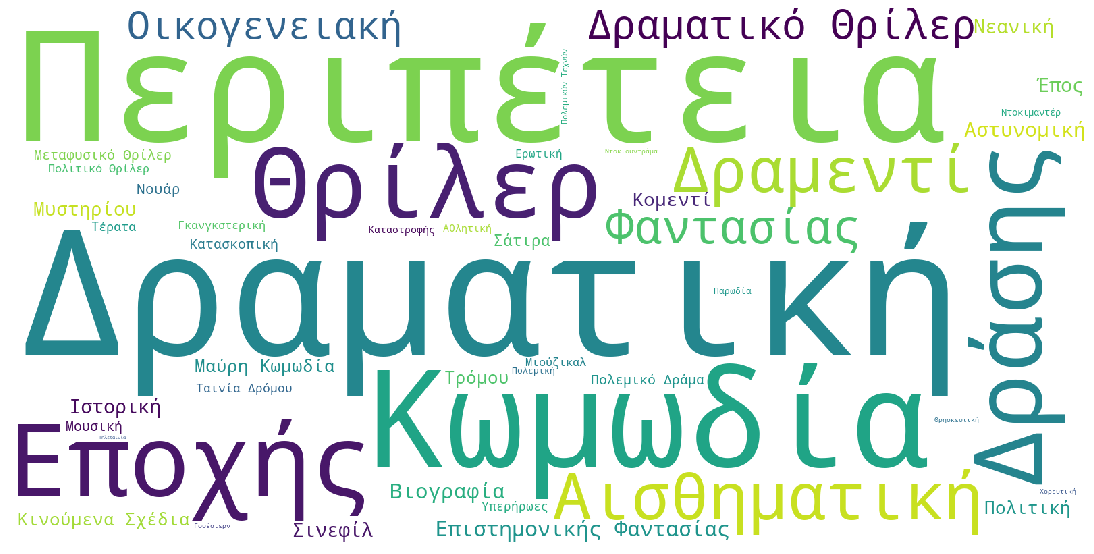

In [9]:
# Calculate the genre frequency
genre_freq = (visualization_df[genre_list].sum()/visualization_df[genre_list].shape[0]).sort_values(ascending=False)

#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='white',width=1600,height=800,).generate_from_frequencies(genre_freq)
fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("genre.png")


It can be seen that the genres `Δραματική`, `Περιπέτεια`, `Κωμωδία`, `Εποχής` and `Θρίλερ` are the most popular ones.


#### Visualize the distribution of movies per genre


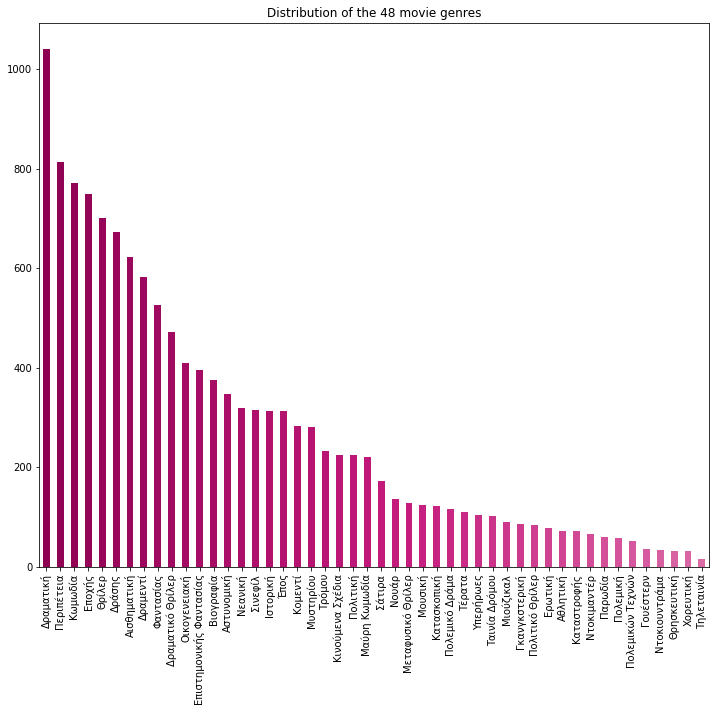

In [10]:
visualization_df[genre_list].sum().sort_values(ascending=False).plot(kind='bar',
                                          figsize=(12,10),
                                          stacked=True, 
                                          color=plt.cm.PiYG(np.arange(len(genre_list))),
                                          title='Distribution of the %d movie genres' % len(genre_list))

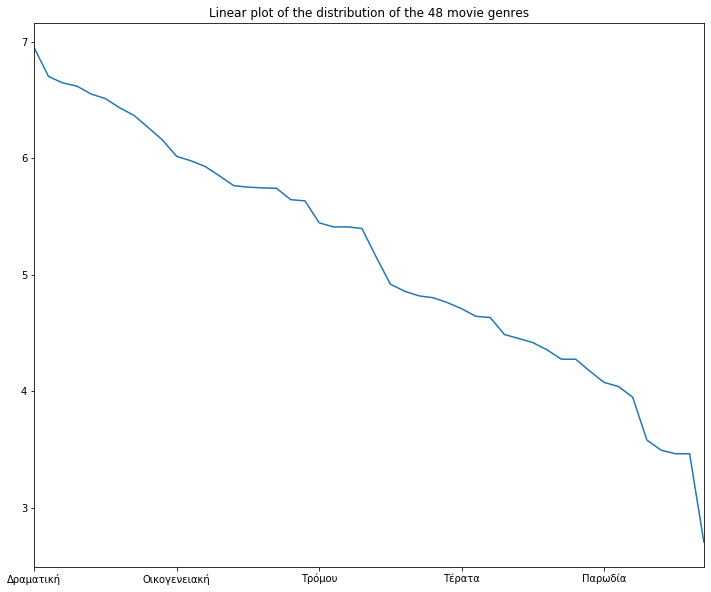

In [11]:
visualization_df[genre_list].sum().sort_values(ascending=False).apply(np.log).plot(figsize=(12,10),
                                                                       stacked=True,
                                                                       title='Linear plot of the distribution of the %d movie genres' % len(genre_list))

It seems that the representation of many less common genres is quite sparse in our dataset. Consequently, we will restrict the possible space of predictable genres by calculating the more prevalent movie genres. In fact we can observe that the movie genre distribution follows a power law distribution [[1]](https://en.wikipedia.org/wiki/Power_law#Scale_invariance). Thus we will investigate the effect of the Pareto Principle [[2]](https://en.wikipedia.org/wiki/Pareto_principle) and keep the top 30% of the most represented genres. 

First we drop the less represented genres and create a list of movies that end up not belonging to any genre, if the number of movies in this list is insignificant we could drop the movies as well. 
Otherwise, we will attempt to infer the genre the best discribes the movie from the list of the most popular genres. This can be done by:

1. exploring the genre correlation
2. calculating the gengre frequency co-occurance in movies that are classified to multiple genres
3. determine the unpopular genre predictability by calculating the genre import through random forests classification


List of the top 30% most represented genres in the dataset:

In [15]:
popularity_df = visualization_df[genre_list].sum().sort_values(ascending=False)[:int(visualization_df.shape[1]*.30)]
popular_genre_list = popularity_df.index
unpopular_genre_list = [genre for genre in genre_list if genre not in popular_genre_list]
unpopular_genre_list

['Ιστορική',
 'Μουσική',
 'Σάτιρα',
 'Υπερήρωες',
 'Μυστηρίου',
 'Χορευτική',
 'Έπος',
 'Ταινία Δρόμου',
 'Ερωτική',
 'Αθλητική',
 'Νεανική',
 'Παρωδία',
 'Μαύρη Κωμωδία',
 'Πολεμικό Δράμα',
 'Τρόμου',
 'Γουέστερν',
 'Κινούμενα Σχέδια',
 'Τέρατα',
 'Πολεμική',
 'Ντοκιμαντέρ',
 'Κατασκοπική',
 'Γκανγκστερική',
 'Μεταφυσικό Θρίλερ',
 'Μιούζικαλ',
 'Σινεφίλ',
 'Πολιτική',
 'Πολεμικών Τεχνών',
 'Νουάρ',
 'Ντοκιουντράμα',
 'Καταστροφής',
 'Πολιτικό Θρίλερ',
 'Κομεντί',
 'Θρησκευτική',
 'Tηλεταινία']

#### Dropping the less popular genres:

In [16]:
genre_popularity_df = movies_df[genre_list].copy()
genre_popularity_df.drop(labels=unpopular_genre_list, axis=1, inplace=True)
genre_popularity_df

,Δράσης,Περιπέτεια,Αισθηματική,Οικογενειακή,Δραματική,Κωμωδία,Δραμεντί,Αστυνομική,Δραματικό Θρίλερ,Θρίλερ,Φαντασίας,Εποχής,Επιστημονικής Φαντασίας,Βιογραφία
0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0,1,0,1,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8855,0,0,0,0,1,0,0,0,0,0,0,1,0,0
8856,0,0,1,0,1,0,0,0,0,0,0,1,0,0
8858,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8859,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Movies not belonging to a genre:

In [17]:
uncategorized_movies_df = movies_df[genre_popularity_df.sum(axis=1)==0]
uncategorized_movies_df.shape

(34, 55)

Eventually only **74 movies remain unassigned** after dropping the unpopular genres. The number of unassigned movies is not detrimental to the sizing of our dataset, thus they can be dropped as well.

In [18]:
movies_df.drop(labels=unpopular_genre_list, axis=1, inplace=True)
movies_df.drop(labels=uncategorized_movies_df.index, axis=0, inplace=True)
movies_df.describe()

,year,Δράσης,Περιπέτεια,Αισθηματική,Οικογενειακή,Δραματική,Κωμωδία,Δραμεντί,Αστυνομική,Δραματικό Θρίλερ,Θρίλερ,Φαντασίας,Εποχής,Επιστημονικής Φαντασίας,Βιογραφία
count,3722.000000,3722.000000,3722.00000,3722.000000,3722.000000,3722.000000,3722.000000,3722.000000,3722.000000,3722.000000,3722.000000,3722.000000,3722.000000,3722.000000,3722.000000
mean,2009.384471,0.180817,0.21870,0.167114,0.110156,0.279420,0.206878,0.156636,0.093229,0.126814,0.188071,0.141053,0.201236,0.106126,0.101021
std,14.308525,0.384918,0.41342,0.373128,0.313126,0.448774,0.405122,0.363506,0.290793,0.332809,0.390821,0.348123,0.400978,0.308040,0.301397
min,1921.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Distribution of the remaining genres and movie count:

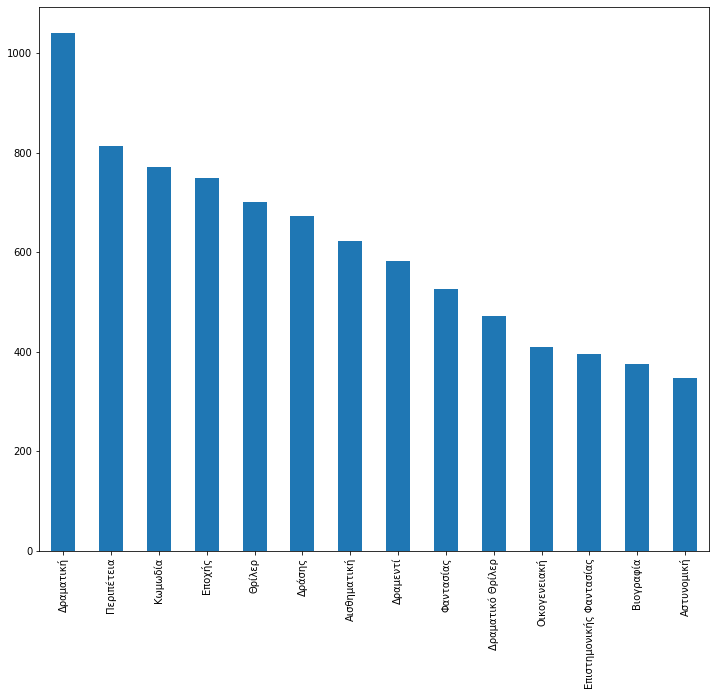

In [22]:
movies_df[popular_genre_list].sum().sort_values(ascending=False).plot(kind='bar', figsize=(12,10),stacked=True)

Exporting cleaned data

In [20]:
movies_df.reset_index(drop=True, inplace=True)
movies_df.to_csv('../data/movieDB_clean.csv')